In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('fraudTest.csv', index_col=0)
data.drop(columns=[
    "cc_num", "first", "last", "street",
    "trans_num", "trans_date_trans_time",
    "job", "merchant", "city", "zip", "dob"
],
          inplace=True)

## Original data set can be found at https://www.kaggle.com/datasets/kartik2112/fraud-detection

In [3]:
data.head()

## Now we proceed to transform categorical variables

,category,amt,gender,state,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
0,personal_care,2.86,M,SC,33.9659,-80.9355,333497,1371816865,33.986391,-81.200714,0
1,personal_care,29.84,F,UT,40.3207,-110.4360,302,1371816873,39.450498,-109.960431,0
2,health_fitness,41.28,F,NY,40.6729,-73.5365,34496,1371816893,40.495810,-74.196111,0
3,misc_pos,60.05,M,FL,28.5697,-80.8191,54767,1371816915,28.812398,-80.883061,0
4,travel,3.19,M,MI,44.2529,-85.0170,1126,1371816917,44.959148,-85.884734,0


In [4]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

gender_le = LabelEncoder()

data['gender'] = gender_le.fit_transform(data['gender'])

category_ohe = OneHotEncoder(drop='first', sparse_output=False)

cols_drop = ['category', 'state']

category_encoded = category_ohe.fit_transform(data[cols_drop])

category_df = pd.DataFrame(category_encoded,
                           columns = category_ohe.get_feature_names_out(cols_drop),
                           index = data.index)

data = pd.concat([data.drop(columns=cols_drop), category_df],
                 axis = 1)

data.head()

X = data.drop(columns=['is_fraud'])
y = data['is_fraud']

## Now the data set is properly encoded and ready for preprocessing

In [5]:
from matplotlib import scale
from sklearn.model_selection import train_test_split

scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=100)
## Stratify makes sure both train and test have the same proportion of the dependent categorical value.

num_cols = ['amt','lat','long','city_pop','unix_time','merch_lat','merch_long']

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.fit_transform(X_test[num_cols])

In [6]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
from scipy import optimize


model = Sequential([
    Input(shape = (X_train.shape[1],)),
    Dense(128),
    LeakyReLU(negative_slope= 0.01),
    Dropout(0.3),
    Dense(64),
    LeakyReLU(negative_slope= 0.01),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer = opt,
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │         9,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,409 (68.00 KB)

 Trainable params: 17,409 (68.00 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
early_stopping = EarlyStopping(
    monitor = 'accuracy',
    patience = 10,
    restore_best_weights = True
)

history = model.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 200,
    batch_size = 2048,
    callbacks = [early_stopping] 
)

Epoch 1/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9988 - loss: 0.0038 - val_accuracy: 0.9971 - val_loss: 0.0135
Epoch 2/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9990 - loss: 0.0033 - val_accuracy: 0.9972 - val_loss: 0.0139
Epoch 3/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9988 - loss: 0.0038 - val_accuracy: 0.9971 - val_loss: 0.0145
Epoch 4/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9987 - loss: 0.0039 - val_accuracy: 0.9972 - val_loss: 0.0138
Epoch 5/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9987 - loss: 0.0039 - val_accuracy: 0.9971 - val_loss: 0.0148
Epoch 6/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9988 - loss: 0.0037 - val_accuracy: 0.9969 - val_loss: 0.0146
Epoch 7/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9987 - loss: 0.0040 - val_accuracy: 0.9970 - val_loss: 0.0159
Epoch 8/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9989 - loss: 0.0037 - val_accu

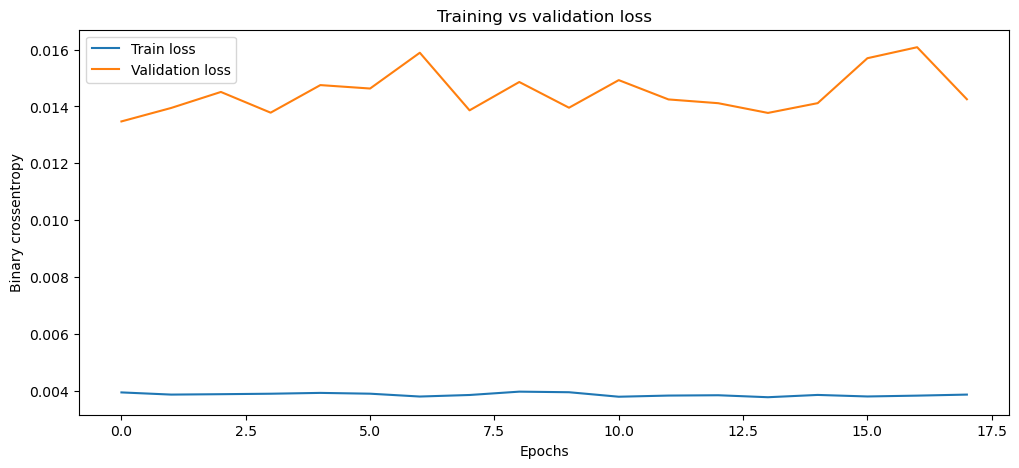

In [16]:
fig, ax = plt.subplots(figsize = (12,5))
ax.plot(history.history['loss'], label = 'Train loss')
ax.plot(history.history['val_loss'], label = 'Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Binary crossentropy')
ax.set_title('Training vs validation loss')
ax.legend()
plt.show()